<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/maxent_ffjord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/xd_vs_flow

/content/drive/My Drive/xd_vs_flow


In [3]:
!pip install torchdiffeq

In [9]:
import os, sys, time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [5]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [6]:
import lib.toy_data as toy_data
import lib.utils as utils
from lib.visualize_flow import visualize_transform
import lib.layers.odefunc as odefunc

from train_misc import standard_normal_logprob
from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
from train_misc import add_spectral_norm, spectral_norm_power_iteration
from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from train_misc import build_model_tabular

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [7]:
# read in 1 Gyr SSFR and 100 Myr SSFR
__ssfr_1gyr = np.load('_ssfr_1gyr.npy')
__ssfr_100myr = np.load('_ssfr_100myr.npy')

_ssfr_1gyr = np.log10(__ssfr_1gyr.copy())
_ssfr_100myr = np.log10(__ssfr_100myr.copy())

N = len(_ssfr_1gyr)
print('N=%i' % N)

npdata = np.array([_ssfr_1gyr, _ssfr_100myr]).T
ss.fit(npdata)
data = torch.from_numpy(npdata.astype(np.float32))

In [13]:
raw_np = np.load('quick_isochrone.npy')
raw_np = raw_np

raw = pd.DataFrame({'G': raw_np[:, 0], 'bp_rp': raw_np[:, 1]})

#Add some noise:
raw['g_std'] = np.random.rand(len(raw))*0.3 + 1e-3
raw['bp_rp_p'] = raw['bp_rp'] + raw['g_std']*np.random.randn(len(raw))
raw['G_p'] = raw['G'] + raw['g_std']*np.random.randn(len(raw))

N = len(raw)
print('N=%i' % N)

use_cols = ['G_p', 'bp_rp_p']#, 'g_std']#, 'BP', 'RP']
cond_cols = []

npdata = np.array(raw[use_cols + cond_cols])
ss.fit(npdata)
data = torch.from_numpy(npdata.astype(np.float32))

N=100000


In [14]:
print(ss.scale_)
print(ss.mean_)

[1.30880609 0.29793693]
[3.45021588 0.10506053]


In [15]:
traindataset = TensorDataset(data[:-(N//5)])
testdataset = TensorDataset(data[-(N//5):])
batch = 1024
train = DataLoader(traindataset, batch_size=batch, shuffle=True, drop_last=True)
test = DataLoader(testdataset, batch_size=batch, shuffle=False)

In [16]:
len(traindataset)/batch

78.125

In [17]:
args = pickle.load(open('args.pkl', 'rb'))

In [58]:
regularization_fns, regularization_coeffs = create_regularization_fns(args)
model = build_model_tabular(args, 2, regularization_fns).cuda()

In [59]:
#if args.spectral_norm: add_spectral_norm(model)
set_cnf_options(args, model)

In [60]:
optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [61]:
transform_scale = torch.from_numpy(ss.scale_).float().cuda()[np.newaxis, :]
transform_mean = torch.from_numpy(ss.mean_).float().cuda()[np.newaxis, :]

def compute_loss(args, model, X, batch_size=None):
    if batch_size is None: batch_size = args.batch_size
    X = X.cuda()

    x = (X - transform_mean)/transform_scale
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    z, delta_logp = model(x, zero)
    #z = model(x)
    
    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)
    #return -torch.mean(logpz)
    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

In [62]:
time_meter = utils.RunningAverageMeter(0.93)
loss_meter = utils.RunningAverageMeter(0.93)
nfef_meter = utils.RunningAverageMeter(0.93)
nfeb_meter = utils.RunningAverageMeter(0.93)
tt_meter = utils.RunningAverageMeter(0.93)

In [63]:
itr = 0

In [64]:
model = model.cuda()
model.train()

SequentialFlow(
  (chain): ModuleList(
    (0): CNF(
      (odefunc): RegularizedODEfunc(
        (odefunc): ODEfunc(
          (diffeq): ODEnet(
            (layers): ModuleList(
              (0): ConcatSquashLinear(
                (_layer): Linear(in_features=2, out_features=64, bias=True)
                (_hyper_bias): Linear(in_features=1, out_features=64, bias=False)
                (_hyper_gate): Linear(in_features=1, out_features=64, bias=True)
              )
              (1): ConcatSquashLinear(
                (_layer): Linear(in_features=64, out_features=64, bias=True)
                (_hyper_bias): Linear(in_features=1, out_features=64, bias=False)
                (_hyper_gate): Linear(in_features=1, out_features=64, bias=True)
              )
              (2): ConcatSquashLinear(
                (_layer): Linear(in_features=64, out_features=64, bias=True)
                (_hyper_bias): Linear(in_features=1, out_features=64, bias=False)
                (_hyper_gate): Li

In [65]:
end = time.time()

while itr < 10000:
    for X in train:
        optimizer.zero_grad()
        #if args.spectral_norm: spectral_norm_power_iteration(model, 1)

        loss = compute_loss(args, model, X[0])

        loss_meter.update(loss.item())
        total_time = count_total_time(model)
        nfe_forward = count_nfe(model)

        loss.backward()
        optimizer.step()

        itr += 1

        if itr % 50 == 0:
            nfe_total = count_nfe(model)
            nfe_backward = nfe_total - nfe_forward
            nfef_meter.update(nfe_forward)
            nfeb_meter.update(nfe_backward)

            time_meter.update(time.time() - end)
            tt_meter.update(total_time)

            log_message = (
                'Iter {:04d} | Time {:.4f}({:.4f}) | Loss {:.6f}({:.6f}) | NFE Forward {:.0f}({:.1f})'
                ' | NFE Backward {:.0f}({:.1f}) | CNF Time {:.4f}({:.4f})'.format(
                    itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg, nfef_meter.val, nfef_meter.avg,
                    nfeb_meter.val, nfeb_meter.avg, tt_meter.val, tt_meter.avg
                )
            )
            print(log_message)

/content/drive/My Drive/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


RuntimeError: ignored

In [27]:
from torch.functional import F

In [28]:
def ezmodel(model, x):
    zero = torch.zeros(x.shape[0], 1)
    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    
    return logpx

def soft_lo_clamp(x, lo):
    return F.softplus(x-lo) + lo

In [30]:
min_1gyr = 0
max_1gyr = 3e-9
min_100myr = 0
max_100myr = 3e-9

num = 100
p_1gyr, p_100myr = np.meshgrid(np.linspace(min_1gyr, max_1gyr, num=num), np.linspace(min_100myr, max_100myr, num=num))
p_1gyr = p_1gyr.reshape(-1)
p_100myr = p_100myr.reshape(-1)

pdatap = np.zeros((len(p_1gyr), 2), dtype=np.float32)
pdatap[:, 0] = p_1gyr
pdatap[:, 1] = p_100myr

pdata = ss.transform(pdatap)

pdata = torch.from_numpy(pdata)#.cuda()
pdata_set = TensorDataset(pdata)
pdata_loader = DataLoader(pdata_set, batch_size=1000, shuffle=False)
model.eval()

logprob = soft_lo_clamp(torch.cat([ezmodel(model, q[:, :2]).cpu().detach() for (q,) in pdata_loader], dim=0), -100).numpy()

_exp = lambda _x: np.exp(_x/4)
prob = _exp(logprob.reshape(num, num))

/content/drive/My Drive/xd_vs_flow/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.


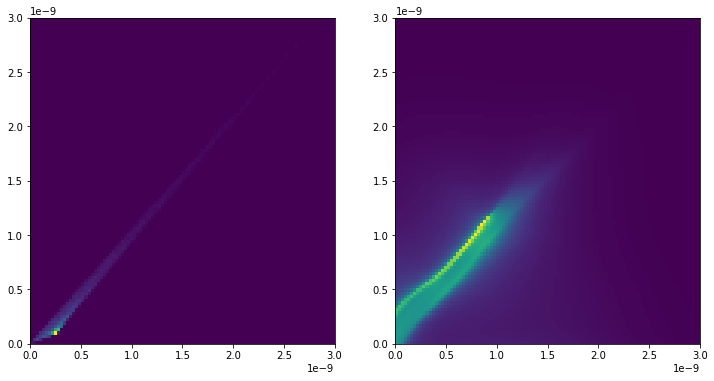

In [35]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
norm = CustomNorm(0.5)
h, _, _, _ = sub.hist2d(_ssfr_1gyr, _ssfr_100myr, bins=100, range=[(min_1gyr, max_1gyr), (min_100myr, max_100myr)], normed=True)

sub = fig.add_subplot(122)
sub.imshow(prob.T, origin='lower', extent=[min_1gyr, max_1gyr, min_100myr, max_100myr], aspect='auto')